In [3]:
# Automatically reload our project Python modules when we run the notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd


raw_data = pd.read_csv("../data/train.csv")
display(raw_data.head())
raw_data.describe()

/var/folders/gp/2lgjxfgd6cs46366l5bz6ny80000gn/T/ipykernel_95091/1403909144.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("../data/train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [14]:
sales_data = raw_data.copy()
sales_data["Date"] = pd.to_datetime(sales_data["Date"])
sales_data = sales_data.rename(columns= {'Date': 'ds', 'Sales': 'y'})

store_id = 4
sales_data_store = sales_data[
        (sales_data['Store'] == store_id) &\
        (sales_data['Open'] == 1)
    ].reset_index(drop=True).sort_values('ds')
display(sales_data_store.head())
sales_data_store.describe()


,Store,DayOfWeek,ds,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
783,4,3,2013-01-02,9941,1429,1,0,0,1
782,4,4,2013-01-03,8247,1248,1,0,0,1
781,4,5,2013-01-04,8290,1232,1,0,0,1
780,4,6,2013-01-05,10338,1514,1,0,0,0
779,4,1,2013-01-07,12112,1562,1,1,0,0


,Store,DayOfWeek,ds,y,Customers,Open,Promo,SchoolHoliday
count,784.0,784.000000,784,784.000000,784.000000,784.0,784.000000,784.000000
mean,4.0,3.506378,2014-04-16 07:26:19.591836672,9638.401786,1321.752551,1.0,0.450255,0.202806
min,4.0,1.000000,2013-01-02 00:00:00,5869.000000,856.000000,1.0,0.000000,0.000000
25%,4.0,2.000000,2013-08-23 18:00:00,8240.500000,1180.000000,1.0,0.000000,0.000000
50%,4.0,3.000000,2014-04-14 12:00:00,9430.500000,1301.500000,1.0,0.000000,0.000000
75%,4.0,5.000000,2014-12-05 06:00:00,10577.250000,1429.250000,1.0,1.000000,0.000000
max,4.0,6.000000,2015-07-31 00:00:00,17412.000000,2216.000000,1.0,1.000000,1.000000
std,0.0,1.711641,NaN,1936.031881,198.347844,0.0,0.497837,0.402346


15:12:38 - cmdstanpy - INFO - Chain [1] start processing
15:12:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/gp/2lgjxfgd6cs46366l5bz6ny80000gn/T/ipykernel_95091/3918327780.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])


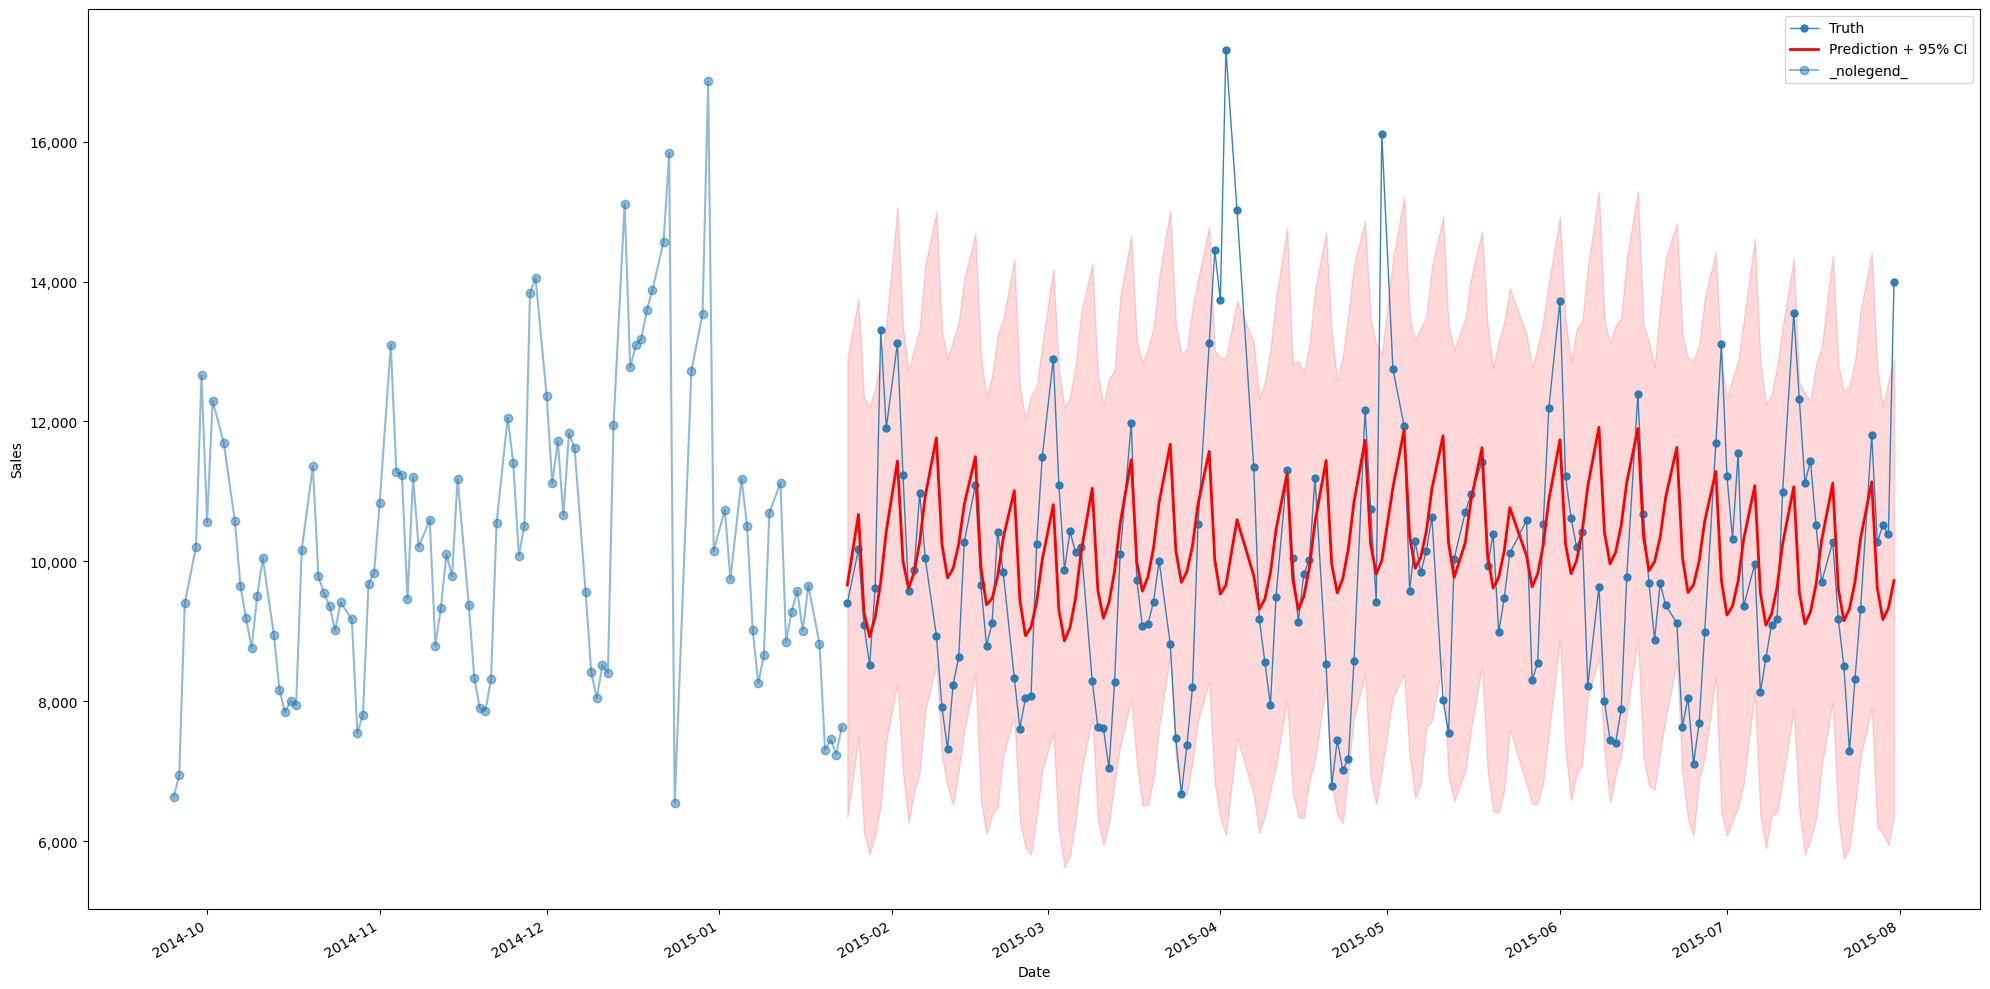

In [21]:
import prophet
from prophet import Prophet
import matplotlib.pyplot as plt

def train_predict(
    df: pd.DataFrame, 
    train_fraction: float, 
    seasonality: dict
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, int]:
    
    # grab split data
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]

    #create Prophet model
    model=Prophet(
        yearly_seasonality=seasonality['yearly'],
        weekly_seasonality=seasonality['weekly'],
        daily_seasonality=seasonality['daily'],
        interval_width = 0.95
    )

    # train and predict
    model.fit(df_train)
    predicted = model.predict(df_test)
    return predicted, df_train, df_test, train_index

def plot_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, predicted: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(20,10))
    df_test.plot(
        x='ds', 
        y='y', 
        ax=ax, 
        label='Truth', 
        linewidth=1, 
        markersize=5, 
        color='tab:blue',
        alpha=0.9, 
        marker='o'
    )
    predicted.plot(
        x='ds', 
        y='yhat', 
        ax=ax, 
        label='Prediction + 95% CI', 
        linewidth=2, 
        markersize=5, 
        color='red'
    )
    ax.fill_between(
        x=predicted['ds'], 
        y1=predicted['yhat_upper'], 
        y2=predicted['yhat_lower'], 
        alpha=0.15, 
        color='red',
    )
    df_train.iloc[train_index-100:].plot(
        x='ds', 
        y='y', 
        ax=ax, 
        color='tab:blue', 
        label='_nolegend_', 
        alpha=0.5, 
        marker='o'
    )
    current_ytick_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.tight_layout()
    plt.savefig('store_data_forecast.png')

predicted, df_train, df_test, train_index = train_predict(
    df=sales_data_store, 
    train_fraction=0.8, 
    seasonality={
        'yearly': True,
        'weekly': True,
        'daily': False
    }
)
plot_forecast(
    df_train=df_train, 
    df_test=df_test, 
    predicted=predicted
)
